# Loading Data

In [3]:
# https://www.figure-eight.com/data-for-everyone/

In [1]:
# pip install requests
import requests

# url = 'https://d1p17r2m4rzlbo.cloudfront.net/wp-content/uploads/2016/03/Apple-Twitter-Sentiment-DFE.csv'
url = 'https://d1p17r2m4rzlbo.cloudfront.net/wp-content/uploads/2016/03/Airline-Sentiment-2-w-AA.csv'
data = requests.get(url)

In [3]:
from io import StringIO

df = pd.read_csv(StringIO(data.text), sep=",") 

In [4]:
df.columns

Index(['_unit_id', '_golden', '_unit_state', '_trusted_judgments',
       '_last_judgment_at', 'airline_sentiment',
       'airline_sentiment:confidence', 'negativereason',
       'negativereason:confidence', 'airline', 'airline_sentiment_gold',
       'name', 'negativereason_gold', 'retweet_count', 'text', 'tweet_coord',
       'tweet_created', 'tweet_id', 'tweet_location', 'user_timezone'],
      dtype='object')

In [5]:
df.shape

(14640, 20)

/Users/tarek/anaconda3/envs/scikitbook/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


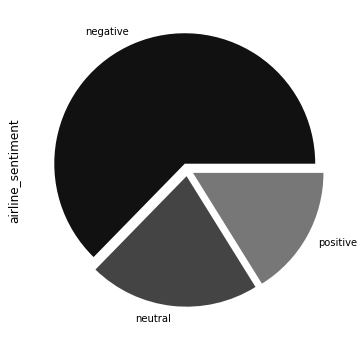

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

explode = (0.05, 0.05, 0.05)
colors = ['#111111', '#444444', '#777777']
df['airline_sentiment'].value_counts().plot(kind='pie', colors=colors, explode=explode, ax=ax)

fig.show()

In [33]:
df['airline_sentiment'].value_counts() / df['airline_sentiment'].shape[0]

negative    0.626913
neutral     0.211680
positive    0.161407
Name: airline_sentiment, dtype: float64

In [34]:
df['negativereason'].value_counts() / df['airline_sentiment'].shape[0]

Customer Service Issue         0.198770
Late Flight                    0.113730
Can't Tell                     0.081284
Cancelled Flight               0.057855
Lost Luggage                   0.049454
Bad Flight                     0.039617
Flight Booking Problems        0.036134
Flight Attendant Complaints    0.032855
longlines                      0.012158
Damaged Luggage                0.005055
Name: negativereason, dtype: float64

In [35]:
pd.options.display.max_colwidth = 90

In [36]:
df[['text', 'airline', 'airline_sentiment:confidence', 'airline_sentiment']].sample(5)

,text,airline,airline_sentiment:confidence,airline_sentiment
12624,@AmericanAir my mom tried also. That wasn't the reason they wouldn't change it. Y'all ...,American,1.0,negative
9090,"@USAirways OK we are on DAY 11 trying to book a flight for 4. Ur system STILL says ""...",US Airways,1.0,negative
33,"@VirginAmerica awaiting my return phone call, just would prefer to use your online sel...",Virgin America,1.0,negative
2168,"@united boarding was decent, 3 useless agents that don't speak English (after 2.5hrs o...",United,1.0,negative
194,@VirginAmerica Just DM'd. Same issue persisting.,Virgin America,1.0,negative


In [37]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df)

In [82]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

y_train = le.fit_transform(df_train['airline_sentiment'])
y_test = le.transform(df_test['airline_sentiment'])

# y_train = df_train['airline_sentiment']
# y_test = df_test['airline_sentiment']

In [39]:
le.classes_.tolist()

['negative', 'neutral', 'positive']

In [40]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(ngram_range=(1,3), min_df=3, strip_accents='ascii')

x_train = vec.fit_transform(df_train['text'])
x_test = vec.transform(df_test['text'])

In [41]:
pd.DataFrame(vec.vocabulary_.items(), columns=['token', 'id']).sort_values('id').set_index('id')

,token
id,
0,00
1,00 pm
2,000
3,000 feet
4,000 miles
...,...
18450,yvr
18451,yvr to
18452,yyz


In [42]:
x_train

<10980x18455 sparse matrix of type '<class 'numpy.int64'>'
	with 283779 stored elements in Compressed Sparse Row format>

In [43]:
x_test

<3660x18455 sparse matrix of type '<class 'numpy.int64'>'
	with 88299 stored elements in Compressed Sparse Row format>

In [104]:
from sklearn.metrics import precision_recall_fscore_support 
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB(fit_prior=True)
clf.fit(x_train, y_train)
y_test_pred = clf.predict(x_test)

p, r, f, s = precision_recall_fscore_support(y_test, y_test_pred)

pd.DataFrame(
    {
        'Precision': p,
        'Recall': r,
        'F': f,
        'Support': s,
    },
    index =le.classes_.tolist()
).round(2)

,Precision,Recall,F,Support
negative,0.85,0.91,0.87,2269
neutral,0.65,0.55,0.60,786
positive,0.74,0.70,0.72,605


In [105]:
pd.Series(p).round(2)

0    0.85
1    0.65
2    0.74
dtype: float64

In [107]:
pd.Series(p).round(2).mean()

0.7466666666666667

In [97]:
y_test_pred = clf.predict(x_test)

p, r, f, s = precision_recall_fscore_support(y_test, y_test_pred, average='macro')

print(f'Macro Precision = {p:.2%} & Recall={r:.2%}')

Macro Precision = 74.76% & Recall=71.92%


In [45]:
precision_recall_fscore_support(y_test, y_test_pred, average='micro')[2]

0.7953551912568306

In [46]:
from sklearn.metrics import precision_recall_fscore_support 
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB(fit_prior=False)
clf.fit(x_train, y_train)
y_test_pred = clf.predict(x_test)

p, r, f, s = precision_recall_fscore_support(y_test, y_test_pred)

pd.DataFrame(
    {
        'Precision': p,
        'Recall': r,
        'F': f,
        'Support': s,
    },
    index =le.classes_.tolist()
)

,Precision,Recall,F,Support
negative,0.877615,0.869105,0.873339,2269
neutral,0.618799,0.603053,0.610825,786
positive,0.701700,0.750413,0.725240,605


In [47]:
precision_recall_fscore_support(y_test, y_test_pred, average='micro')[2]

0.7923497267759563

Micro FScore = 0.7775956284153005 @ ngram_range = (1, 1)
Micro FScore = 0.7191256830601092 @ ngram_range = (2, 2)
Micro FScore = 0.6144808743169399 @ ngram_range = (3, 3)
Micro FScore = 0.6415300546448087 @ ngram_range = (4, 4)
Micro FScore = 0.6319672131147541 @ ngram_range = (5, 5)
Micro FScore = 0.6281420765027322 @ ngram_range = (6, 6)
Micro FScore = 0.6281420765027322 @ ngram_range = (7, 7)
Micro FScore = 0.6267759562841531 @ ngram_range = (8, 8)


/Users/tarek/anaconda3/envs/scikitbook/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


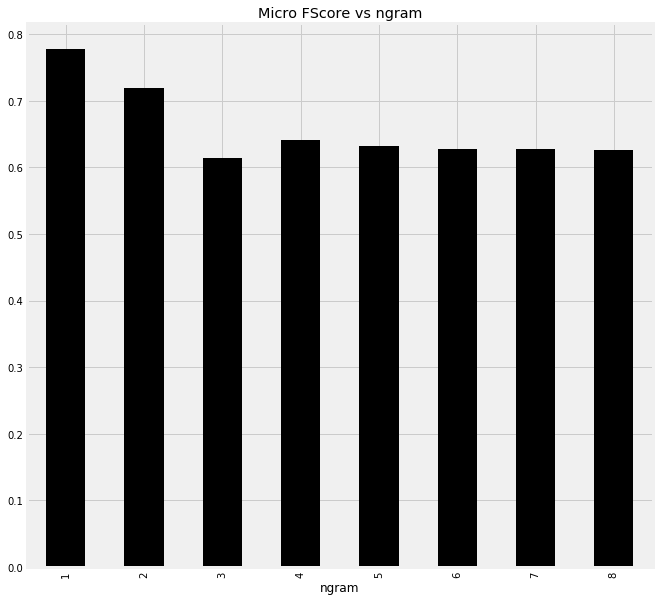

In [48]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

micro_fscores = []

for ngram_range in [(1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8)]:

    pipeline = make_pipeline(
        CountVectorizer(ngram_range=ngram_range, min_df=3, max_df=0.2, strip_accents='ascii'),
        MultinomialNB(fit_prior=False)
    )

    pipeline.fit(df_train['text'], y_train)
    y_test_pred =  pipeline.predict(df_test['text'])

    p, r, f, s = precision_recall_fscore_support(y_test, y_test_pred)

    micro_fscore = precision_recall_fscore_support(y_test, y_test_pred, average='micro')[2]

    print(f'Micro FScore = {micro_fscore} @ ngram_range = {ngram_range}')
    
    micro_fscores.append([ngram_range[-1], micro_fscore])
    
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

pd.DataFrame(
    micro_fscores,
    columns=['ngram', 'Micro FScore']
).set_index('ngram')['Micro FScore'].plot(
    title='Micro FScore vs ngram',
    color='k',
    kind='bar',
    ax=ax,
)

fig.show()

/Users/tarek/anaconda3/envs/scikitbook/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


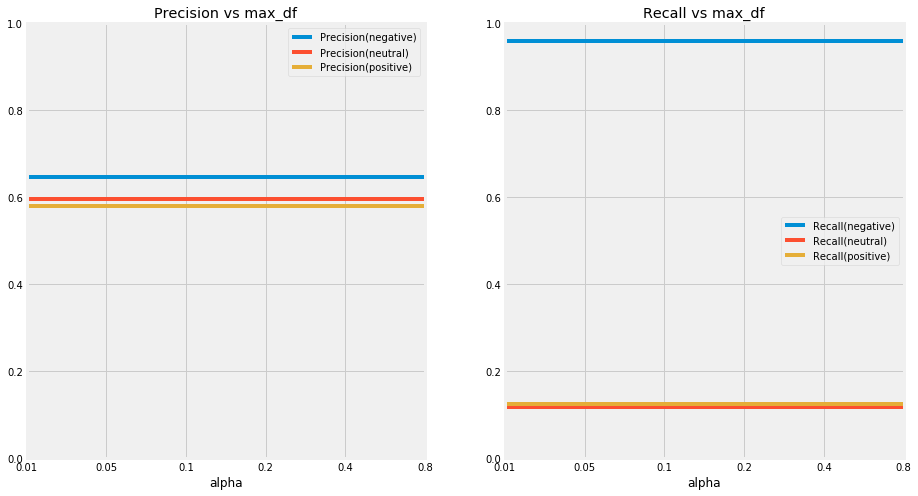

In [49]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

precision_scores = []
recall_scores = []

for max_df in [.01, .05, .1, .2, .4, .8]:

    pipeline = make_pipeline(
        CountVectorizer(ngram_range=(4,4), min_df=3, max_df=max_df, strip_accents='ascii'),
        MultinomialNB(fit_prior=False, alpha=1)
    )

    pipeline.fit(df_train['text'], y_train)
    y_test_pred =  pipeline.predict(df_test['text'])

    p, r, f, s = precision_recall_fscore_support(y_test, y_test_pred)
    
    precision_score = [f'{max_df}']
    precision_score.extend(p)
    
    recall_score = [f'{max_df}']
    recall_score.extend(r)
    
    precision_scores.append(precision_score)
    recall_scores.append(recall_score)
    
fig, axs = plt.subplots(1, 2, figsize=(14, 8))

pd.DataFrame(
    precision_scores,
    columns=['alpha', 'Precision(negative)', 'Precision(neutral)', 'Precision(positive)']
).set_index('alpha').plot(
    title='Precision vs max_df',
    # color='k',
    kind='line',
    ylim=(0,1),
    ax=axs[0],
)

pd.DataFrame(
    recall_scores,
    columns=['alpha', 'Recall(negative)', 'Recall(neutral)', 'Recall(positive)']
).set_index('alpha').plot(
    title='Recall vs max_df',
    # color='k',
    kind='line',
    ylim=(0,1),
    ax=axs[1],
)

fig.show()

# GridSearch + Pipeline

In [83]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

pipe = Pipeline(steps=[('CountVectorizer', CountVectorizer()), ('MultinomialNB', MultinomialNB())])

In [84]:
param_grid = {
    'CountVectorizer__ngram_range': [(1,1), (1,2), (1,3)],
    'MultinomialNB__alpha': [0.1, 1],
    'MultinomialNB__fit_prior': [True, False],
}

In [85]:
from sklearn.model_selection import GridSearchCV

search = GridSearchCV(pipe, param_grid, scoring='precision_macro', n_jobs=-1)
search.fit(df_train['text'], y_train)
print(search.best_params_)

{'CountVectorizer__ngram_range': (1, 3), 'MultinomialNB__alpha': 1, 'MultinomialNB__fit_prior': True}


In [86]:
y_test_pred = search.predict(df_test['text'])

p, r, f, s = precision_recall_fscore_support(y_test, y_test_pred, average='macro')

print(f'Macro Precision = {p:.2%} & Recall={r:.2%}')

Macro Precision = 78.49% & Recall=51.18%


In [87]:
from sklearn.model_selection import GridSearchCV

search = GridSearchCV(pipe, param_grid, scoring='recall_macro', n_jobs=-1)
search.fit(df_train['text'], y_train)
print(search.best_params_)

{'CountVectorizer__ngram_range': (1, 1), 'MultinomialNB__alpha': 0.1, 'MultinomialNB__fit_prior': False}


In [88]:
y_test_pred = search.predict(df_test['text'])

p, r, f, s = precision_recall_fscore_support(y_test, y_test_pred, average='macro')

print(f'Macro Precision = {p:.2%} & Recall={r:.2%}')

Macro Precision = 70.79% & Recall=72.01%


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(ngram_range=(1,3), min_df=3, max_df=0.2, binary=True, strip_accents='ascii')

x_train = vec.fit_transform(df_train['text'])
x_test = vec.transform(df_test['text'])

In [ ]:
from sklearn.metrics import precision_recall_fscore_support 
from sklearn.naive_bayes import BernoulliNB

clf = BernoulliNB(fit_prior=False)
clf.fit(x_train, y_train)
y_test_pred = clf.predict(x_test)

p, r, f, s = precision_recall_fscore_support(y_test, y_test_pred)

pd.DataFrame(
    {
        'Precision': p,
        'Recall': r,
        'F': f,
        'Support': s,
    },
    index =le.classes_.tolist()
)

In [ ]:
precision_recall_fscore_support(y_test, y_test_pred, average='micro')[2]

In [ ]:
df_vocab = pd.DataFrame(vec.vocabulary_.items(), columns=['token', 'id']).sort_values('id').set_index('id')

c1, c2, c3 = clf.coef_

df_vocab['negative_coef'] = c1
df_vocab['neutral_coef'] = c2
df_vocab['positive_coef'] = c3

In [ ]:
df_vocab.sort_values('negative_coef', ascending=False).head(20)

In [ ]:
df_vocab.sort_values('positive_coef', ascending=False).head(20)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support 
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(x_train, y_train)
y_test_pred = clf.predict(x_test)

p, r, f, s = precision_recall_fscore_support(y_test, y_test_pred)

pd.DataFrame(
    {
        'Precision': p,
        'Recall': r,
        'F': f,
        'Support': s,
    },
    index =le.classes_.tolist()
)


In [ ]:
precision_recall_fscore_support(y_test, y_test_pred, average='micro')[2]

In [342]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer(ngram_range=(1,3), sublinear_tf=True)

x_train = vec.fit_transform(df_train['text'])
x_test = vec.transform(df_test['text'])

In [343]:
from sklearn.metrics import precision_recall_fscore_support 
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB(fit_prior=False, alpha=0.001)
clf.fit(x_train, y_train)
y_test_pred = clf.predict(x_test)

p, r, f, s = precision_recall_fscore_support(y_test, y_test_pred)

pd.DataFrame(
    {
        'Precision': p,
        'Recall': r,
        'F': f,
        'Support': s,
    },
    index =le.classes_.tolist()
)

,Precision,Recall,F,Support
negative,0.804869,0.917621,0.857555,2270
neutral,0.648551,0.450882,0.531947,794
positive,0.694231,0.605705,0.646953,596


In [344]:
precision_recall_fscore_support(y_test, y_test_pred, average='micro')[1]

0.7655737704918033

In [345]:
df_vocab = pd.DataFrame(vec.vocabulary_.items(), columns=['token', 'id']).sort_values('id').set_index('id')

c1, c2, c3 = clf.coef_

df_vocab['negative_coef'] = c1
df_vocab['neutral_coef'] = c2
df_vocab['positive_coef'] = c3

In [346]:
df_vocab.sort_values('negative_coef', ascending=False).head(20)

,token,negative_coef,neutral_coef,positive_coef
id,,,,
191557,to,-5.915192,-5.828423,-6.100844
181012,the,-6.116753,-6.152994,-5.871366
202738,united,-6.232380,-6.088073,-6.012418
68961,flight,-6.257911,-6.453387,-6.662051
18665,and,-6.294188,-6.808669,-6.513998
138807,on,-6.297872,-6.328405,-6.743613
208293,usairways,-6.299983,-6.626311,-6.446595
226678,you,-6.341896,-6.138289,-5.509187
74982,for,-6.352966,-6.487227,-6.033189


In [348]:
# pip install spacy
# python -m spacy download en_core_web_lg

In [1]:
%autoreload

reload(spacy)

UsageError: Line magic function `%autoreload` not found.


In [2]:
import spacy

nlp = spacy.load('en_core_web_md')

In [108]:
# pip install tqdm
from tqdm import tqdm
tqdm.pandas()

In [91]:
import spacy

class WordEmbeddingVectorizer:
    
    def __init__(self, language_model='en_core_web_md'):
        self.nlp = spacy.load(language_model)
    
    def fit(self):
        pass
    
    def transform(self, x, y=None):
        return pd.Series(x).progress_apply(
            lambda doc: self.nlp(doc).vector.tolist()
        ).values.tolist()
    
    def fit_transform(self, x, y=None):
        return self.transform(x)
    

vec = WordEmbeddingVectorizer()
x_train_w2v = vec.transform(df_train['text'])
x_test_w2v = vec.transform(df_test['text'])

100%|██████████| 3660/3660 [00:50<00:00, 73.01it/s] 


In [92]:
from sklearn.metrics import precision_recall_fscore_support 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

scaler = StandardScaler()
# clf = SGDClassifier(loss='log', max_iter=10000, class_weight='balanced')
clf = LogisticRegression(max_iter=10000, class_weight=None)

x_train_scaled = scaler.fit_transform(x_train_w2v)
x_test_scaled = scaler.transform(x_test_w2v)

clf.fit(x_train_scaled, y_train)
y_test_pred = clf.predict(x_test_scaled)

p, r, f, s = precision_recall_fscore_support(y_test, y_test_pred)

pd.DataFrame(
    {
        'Precision': p,
        'Recall': r,
        'F': f,
        'Support': s,
    },
    index =le.classes_.tolist()
)


,Precision,Recall,F,Support
negative,0.846433,0.911063,0.877560,2305
neutral,0.653614,0.560000,0.603197,775
positive,0.724272,0.643103,0.681279,580


In [93]:
precision_recall_fscore_support(y_test, y_test_pred, average='micro')[1]

0.7942622950819672

In [94]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=3, metric='cosine')

clf.fit(x_train_w2v, y_train)
y_test_pred = clf.predict(x_test_w2v)

p, r, f, s = precision_recall_fscore_support(y_test, y_test_pred)

pd.DataFrame(
    {
        'Precision': p,
        'Recall': r,
        'F': f,
        'Support': s,
    },
    index =le.classes_.tolist()
)


,Precision,Recall,F,Support
negative,0.744674,0.940130,0.831064,2305
neutral,0.671779,0.282581,0.397820,775
positive,0.667453,0.487931,0.563745,580


In [95]:
precision_recall_fscore_support(y_test, y_test_pred, average='micro')[1]

0.7292349726775956